In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
import json
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import gensim.downloader as api
from keras.models import Model
from keras.layers import Embedding, Bidirectional, LSTM, Dense, TimeDistributed, Dropout, Input, Concatenate, Dot, Activation, multiply
from sklearn.metrics import classification_report
from gensim.models import KeyedVectors
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
word_vectors = api.load('glove-wiki-gigaword-200')

[==================================================] 100.0% 252.1/252.1MB downloaded


In [ ]:
def process_data(data):
    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)

    tokens_list = []
    aspects_list = []
    bio_tags_list = []
    token_length_list = []
    pos_tags_list = []

    for entry in data:
        tokens = [token for token in entry["token"] if token not in punctuation]
        aspects = entry.get("aspects", [])
        pos_tags = nltk.pos_tag(tokens)

        unique_aspects = []
        bio_tags = ['O'] * len(tokens)

        for aspect in aspects:
            term = [char for char in aspect.get("term", []) if char not in punctuation]
            unique_aspects.append(''.join(term))

            for i in range(len(tokens)):
                if tokens[i:i + len(term)] == term:
                    if i > 0 and bio_tags[i - 1] == 'B':
                        bio_tags[i] = 'I'
                    else:
                        bio_tags[i] = 'B'
                    if len(term) > 1:
                        bio_tags[i + 1:i + len(term)] = ['I'] * (len(term) - 1)

        filtered_tokens = tokens
        filtered_bio_tags = bio_tags
        filtered_pos_tags = [tag[1] for tag in pos_tags]

        tokens_list.append(filtered_tokens)
        aspects_list.append(unique_aspects)
        bio_tags_list.append(filtered_bio_tags)
        token_length_list.append([len(token) for token in filtered_tokens])
        pos_tags_list.append(filtered_pos_tags)

    df_result = pd.DataFrame({
        'token': tokens_list,
        'aspect': aspects_list,
        'bioTag': bio_tags_list,
        'pos': pos_tags_list,  # Add POS tags as a new column
    })

    return df_result


In [ ]:
# Load All Dataset
laptop_train_json_file_path = '/content/drive/MyDrive/Common files/Common files/Dataset/Laptops/train.json'
with open(laptop_train_json_file_path, 'r') as file:
    laptop_train_data = json.load(file)
laptop_test_json_file_path = '/content/drive/MyDrive/Common files/Common files/Dataset/Laptops/test.json'
with open(laptop_test_json_file_path, 'r') as file:
    laptop_test_data = json.load(file)
laptop_valid_json_file_path = '/content/drive/MyDrive/Common files/Common files/Dataset/Laptops/valid.json'
with open(laptop_valid_json_file_path, 'r') as file:
    laptop_valid_data = json.load(file)


mams_train_json_file_path = '/content/drive/MyDrive/Common files/Common files/Dataset/MAMS/train.json'
with open(mams_train_json_file_path, 'r') as file:
    mams_train_data = json.load(file)
mams_test_json_file_path = '/content/drive/MyDrive/Common files/Common files/Dataset/MAMS/test.json'
with open(mams_test_json_file_path, 'r') as file:
    mams_test_data = json.load(file)
mams_valid_json_file_path = '/content/drive/MyDrive/Common files/Common files/Dataset/MAMS/valid.json'
with open(mams_valid_json_file_path, 'r') as file:
    mams_valid_data = json.load(file)


res_train_json_file_path = '/content/drive/MyDrive/Common files/Common files/Dataset/Restaurants/train.json'
with open(res_train_json_file_path, 'r') as file:
    res_train_data = json.load(file)
res_test_json_file_path = '/content/drive/MyDrive/Common files/Common files/Dataset/Restaurants/test.json'
with open(res_test_json_file_path, 'r') as file:
    res_test_data = json.load(file)
res_valid_json_file_path = '/content/drive/MyDrive/Common files/Common files/Dataset/Restaurants/valid.json'
with open(res_valid_json_file_path, 'r') as file:
    res_valid_data = json.load(file)


tweet_train_json_file_path = '/content/drive/MyDrive/Common files/Common files/Dataset/Tweets/train.json'
with open(tweet_train_json_file_path, 'r') as file:
    tweet_train_data = json.load(file)
tweet_test_json_file_path = '/content/drive/MyDrive/Common files/Common files/Dataset/Tweets/test.json'
with open(tweet_test_json_file_path, 'r') as file:
    tweet_test_data = json.load(file)
tweet_valid_json_file_path = '/content/drive/MyDrive/Common files/Common files/Dataset/Tweets/valid.json'
with open(tweet_valid_json_file_path, 'r') as file:
    tweet_valid_data = json.load(file)

In [ ]:
laptop_df_train = process_data(laptop_train_data)
laptop_df_test = process_data(laptop_test_data)
laptop_df_valid = process_data(laptop_valid_data)

mams_df_train = process_data(mams_train_data)
mams_df_test = process_data(mams_test_data)
mams_df_valid = process_data(mams_valid_data)

res_df_train = process_data(res_train_data)
res_df_test = process_data(res_test_data)
res_df_valid = process_data(res_valid_data)

tweet_df_train = process_data(tweet_train_data)
tweet_df_test = process_data(tweet_test_data)
tweet_df_valid = process_data(tweet_valid_data)


In [ ]:
# Adjust tokenizer with a fixed maximum vocabulary size
MAX_VOCAB_SIZE = 5000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
# Set a fixed maximum sequence length
max_seq_length = 200
tag_to_index = {'O': 0, 'B': 1, 'I': 2,'PAD':3}
embedding_dim = 200  # Adjust based on the GloVe file you downloaded
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in word_vectors:
        embedding_matrix[i] = word_vectors[word]

In [ ]:

def tokenize_padded_data(df_train, df_test, df_valid, tokenizer, tag_to_index, max_seq_length):
    # Fit the tokenizer on the training data
    tokenizer.fit_on_texts(df_train['token'])
    tokenizer.fit_on_texts(df_train['pos'])

    # Pad token sequences with the fixed maximum sequence length
    X_train = pad_sequences(tokenizer.texts_to_sequences(df_train['token']), maxlen=max_seq_length, padding='post', truncating='post')
    X_test = pad_sequences(tokenizer.texts_to_sequences(df_test['token']), maxlen=max_seq_length, padding='post', truncating='post')
    X_val = pad_sequences(tokenizer.texts_to_sequences(df_valid['token']), maxlen=max_seq_length, padding='post', truncating='post')

    # Pad POS sequences with the fixed maximum sequence length
    pos_vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size for POS tags
    X_train_pos = pad_sequences(tokenizer.texts_to_sequences(df_train['pos']), maxlen=max_seq_length, padding='post', truncating='post')
    X_test_pos = pad_sequences(tokenizer.texts_to_sequences(df_test['pos']), maxlen=max_seq_length, padding='post', truncating='post')
    X_val_pos = pad_sequences(tokenizer.texts_to_sequences(df_valid['pos']), maxlen=max_seq_length, padding='post', truncating='post')

    # Pad BIO tag sequences with the fixed maximum sequence length
    y_train = pad_sequences([[tag_to_index[tag] for tag in seq] for seq in df_train['bioTag']], padding='post', value=tag_to_index['PAD'], maxlen=max_seq_length)
    y_test = pad_sequences([[tag_to_index[tag] for tag in seq] for seq in df_test['bioTag']], padding='post', value=tag_to_index['PAD'], maxlen=max_seq_length)
    y_val = pad_sequences([[tag_to_index[tag] for tag in seq] for seq in df_valid['bioTag']], padding='post', value=tag_to_index['PAD'], maxlen=max_seq_length)

    # Convert numerical representations to one-hot encoding
    y_train = to_categorical(y_train, num_classes=len(tag_to_index))
    y_test = to_categorical(y_test, num_classes=len(tag_to_index))
    y_val = to_categorical(y_val, num_classes=len(tag_to_index))

    return X_train, X_test, X_val, X_train_pos, X_test_pos, X_val_pos, y_train, y_test, y_val, pos_vocab_size

# Example usage:

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')

# Assuming laptop_df_train, laptop_df_test, laptop_df_valid are your DataFrames for the laptop domain
laptop_X_train, laptop_X_test, laptop_X_val, laptop_X_train_pos, laptop_X_test_pos, laptop_X_val_pos, laptop_y_train, laptop_y_test, laptop_y_val, pos_vocab_size = tokenize_padded_data(laptop_df_train, laptop_df_test, laptop_df_valid, tokenizer, tag_to_index, max_seq_length)
res_X_train, res_X_test, res_X_val, res_X_train_pos, res_X_test_pos, res_X_val_pos, res_y_train, res_y_test, res_y_val, pos_vocab_size = tokenize_padded_data(res_df_train, res_df_test, res_df_valid, tokenizer,tag_to_index, max_seq_length)
tweet_X_train, tweet_X_test, tweet_X_val, tweet_X_train_pos, tweet_X_test_pos, tweet_X_val_pos, tweet_y_train, tweet_y_test, tweet_y_val, pos_vocab_size = tokenize_padded_data(tweet_df_train, tweet_df_test, tweet_df_valid, tokenizer, tag_to_index, max_seq_length)
mams_X_train, mams_X_test, mams_X_val, mams_X_train_pos, mams_X_test_pos, mams_X_val_pos, mams_y_train, mams_y_test, mams_y_val, pos_vocab_size = tokenize_padded_data(mams_df_train, mams_df_test, mams_df_valid, tokenizer, tag_to_index , max_seq_length)



# Define L2 regularization strength
l2_reg = 0.01

# Update model architecture with regularization and class weights
def create_model_with_position_embeddings(embedding_matrix, max_seq_length, max_pos_length):
    # Input layers
    token_input_layer = Input(shape=(max_seq_length,))
    pos_input_layer = Input(shape=(max_seq_length,))

    # Word embedding layer
    word_embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],
                                     output_dim=embedding_matrix.shape[1],
                                     input_length=max_seq_length,
                                     weights=[embedding_matrix],
                                     trainable=True, mask_zero=True)
    token_embedding = word_embedding_layer(token_input_layer)

    # Positional embedding layer
    pos_embedding_layer = Embedding(input_dim=pos_vocab_size,
                                    output_dim=50,
                                    input_length=max_seq_length)
    pos_embedding = pos_embedding_layer(pos_input_layer)

    # Concatenate token embeddings and positional embeddings
    combined_embedding = Concatenate(axis=-1)([token_embedding, pos_embedding])

    # Dropout layer
    dropout_emb = Dropout(0.5)(combined_embedding)

    # Regularization layer
    reg_emb = TimeDistributed(Dense(512, activation='relu', kernel_regularizer=l2(l2_reg)))(dropout_emb)

    # Attention Mechanism
    attention = TimeDistributed(Dense(512, activation='relu'))(reg_emb)
    attention = TimeDistributed(Dense(1))(attention)
    attention = TimeDistributed(Dense(128, activation='relu'))(attention)
    attention = TimeDistributed(Dense(1))(attention)
    attention = Activation('softmax')(attention)

    # Apply attention weights
    sent_representation = multiply([reg_emb, attention])

    # Bidirectional LSTM layer
    lstm = Bidirectional(LSTM(units=100, return_sequences=True))(sent_representation)

    # Self-Attention Mechanism
    self_attention = Dot(axes=[2, 2])([lstm, lstm])
    self_attention = Activation('softmax')(self_attention)

    # Combine attention and self-attention
    combined_attention = Concatenate(axis=-1)([lstm, self_attention])

    # Feedforward layers with regularization
    output = TimeDistributed(Dense(128, activation='tanh', kernel_regularizer=l2(l2_reg)))(combined_attention)
    output = Dropout(0.1)(output)
    output = TimeDistributed(Dense(4, activation='softmax'))(output)  # Assuming 3 classes: 'O', 'B', 'I'

    # Create model
    model = Model(inputs=[token_input_layer, pos_input_layer], outputs=output)

    return model

In [ ]:
# Define static class weights
  # Adjust weights based on the classification report

print("########################################################## Laptop ########################################################")
laptop_model_with_position_embeddings = create_model_with_position_embeddings(embedding_matrix, max_seq_length, len(tag_to_index))
laptop_model_with_position_embeddings.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
laptop_early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
laptop_history = laptop_model_with_position_embeddings.fit([laptop_X_train, laptop_X_train_pos], laptop_y_train, validation_data=([laptop_X_val, laptop_X_val_pos], laptop_y_val), epochs=50,batch_size=32,callbacks=[laptop_early_stopping])

print("########################################################## Restaurant ########################################################")
res_model_with_position_embeddings = create_model_with_position_embeddings(embedding_matrix, max_seq_length, len(tag_to_index))
res_model_with_position_embeddings.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
res_early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
res_history = res_model_with_position_embeddings.fit([res_X_train, res_X_train_pos], res_y_train, validation_data=([res_X_val, res_X_val_pos], res_y_val), epochs=50,batch_size=32,callbacks=[res_early_stopping])


print("########################################################## Tweets ########################################################")
tweet_model_with_position_embeddings = create_model_with_position_embeddings(embedding_matrix, max_seq_length, len(tag_to_index))
tweet_model_with_position_embeddings.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
tweet_early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
tweet_history = tweet_model_with_position_embeddings.fit([tweet_X_train, tweet_X_train_pos], tweet_y_train, validation_data=([tweet_X_val, tweet_X_val_pos], tweet_y_val), epochs=50,batch_size=32,callbacks=[tweet_early_stopping])


print("########################################################## MAMS ########################################################")
mams_model_with_position_embeddings = create_model_with_position_embeddings(embedding_matrix, max_seq_length, len(tag_to_index))
mams_model_with_position_embeddings.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
mams_early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
mams_history = mams_model_with_position_embeddings.fit([mams_X_train, mams_X_train_pos], mams_y_train, validation_data=([mams_X_val, mams_X_val_pos], mams_y_val), epochs=50,batch_size=32,callbacks=[mams_early_stopping])


########################################################## Laptop ########################################################
Epoch 1/50
46/46 [==============================] - 27s 238ms/step - loss: 3.4310 - accuracy: 0.8509 - val_loss: 1.6838 - val_accuracy: 0.8201
Epoch 2/50
46/46 [==============================] - 5s 101ms/step - loss: 0.9931 - accuracy: 0.8663 - val_loss: 0.7310 - val_accuracy: 0.8201
Epoch 3/50
46/46 [==============================] - 3s 67ms/step - loss: 0.4941 - accuracy: 0.8664 - val_loss: 0.5062 - val_accuracy: 0.8201
Epoch 4/50
46/46 [==============================] - 3s 60ms/step - loss: 0.3688 - accuracy: 0.8690 - val_loss: 0.4496 - val_accuracy: 0.8300
Epoch 5/50
46/46 [==============================] - 3s 53ms/step - loss: 0.3402 - accuracy: 0.8724 - val_loss: 0.4165 - val_accuracy: 0.8376
Epoch 6/50
46/46 [==============================] - 2s 53ms/step - loss: 0.3272 - accuracy: 0.8742 - val_loss: 0.3892 - val_accuracy: 0.8465
Epoch 7/50
46/46 [==========

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Make predictions on the test set
laptop_y_pred = laptop_model_with_position_embeddings.predict([laptop_X_test, laptop_X_test_pos])
res_y_pred = res_model_with_position_embeddings.predict([res_X_test, res_X_test_pos])
tweet_y_pred = tweet_model_with_position_embeddings.predict([tweet_X_test, tweet_X_test_pos])
mams_y_pred = mams_model_with_position_embeddings.predict([mams_X_test, mams_X_test_pos])

# Convert predictions and true labels from one-hot encoding to labels
laptop_y_pred_labels = np.argmax(laptop_y_pred, axis=-1)
laptop_y_test_labels = np.argmax(laptop_y_test, axis=-1)

res_y_pred_labels = np.argmax(res_y_pred, axis=-1)
res_y_test_labels = np.argmax(res_y_test, axis=-1)

tweet_y_pred_labels = np.argmax(tweet_y_pred, axis=-1)
tweet_y_test_labels = np.argmax(tweet_y_test, axis=-1)

mams_y_pred_labels = np.argmax(mams_y_pred, axis=-1)
mams_y_test_labels = np.argmax(mams_y_test, axis=-1)

# Flatten the predictions and true labels to prepare for classification_report
laptop_y_pred_labels_flat = laptop_y_pred_labels.flatten()
laptop_y_test_labels_flat = laptop_y_test_labels.flatten()

res_y_pred_labels_flat = res_y_pred_labels.flatten()
res_y_test_labels_flat = res_y_test_labels.flatten()

tweet_y_pred_labels_flat = tweet_y_pred_labels.flatten()
tweet_y_test_labels_flat = tweet_y_test_labels.flatten()

mams_y_pred_labels_flat = mams_y_pred_labels.flatten()
mams_y_test_labels_flat = mams_y_test_labels.flatten()


# Generate classification report
class_names = ['O', 'B', 'I']
# Filter out 'PAD' tag from predictions and true labels
laptop_non_pad_indices = laptop_y_test_labels_flat != tag_to_index['PAD']
laptop_y_pred_labels_filtered = laptop_y_pred_labels_flat[laptop_non_pad_indices]
laptop_y_test_labels_filtered = laptop_y_test_labels_flat[laptop_non_pad_indices]

res_non_pad_indices = res_y_test_labels_flat != tag_to_index['PAD']
res_y_pred_labels_filtered = res_y_pred_labels_flat[res_non_pad_indices]
res_y_test_labels_filtered = res_y_test_labels_flat[res_non_pad_indices]

tweet_non_pad_indices = tweet_y_test_labels_flat != tag_to_index['PAD']
tweet_y_pred_labels_filtered = tweet_y_pred_labels_flat[tweet_non_pad_indices]
tweet_y_test_labels_filtered = tweet_y_test_labels_flat[tweet_non_pad_indices]

mams_non_pad_indices = mams_y_test_labels_flat != tag_to_index['PAD']
mams_y_pred_labels_filtered = mams_y_pred_labels_flat[mams_non_pad_indices]
mams_y_test_labels_filtered = mams_y_test_labels_flat[mams_non_pad_indices]

# Generate classification report
laptop_report = classification_report(laptop_y_test_labels_filtered, laptop_y_pred_labels_filtered, target_names=class_names)
res_report = classification_report(res_y_test_labels_filtered, res_y_pred_labels_filtered, target_names=class_names)
tweet_report = classification_report(tweet_y_test_labels_filtered, tweet_y_pred_labels_filtered, target_names=class_names)
mams_report = classification_report(mams_y_test_labels_filtered, mams_y_pred_labels_filtered, target_names=class_names)




# Print classification report
print("##########################################################  Laptop  #############################################")
print("Laptop Classification Report (excluding PAD tag):")
print(laptop_report)
laptop_accuracy = accuracy_score(laptop_y_test_labels_filtered, laptop_y_pred_labels_filtered)
print("Laptop Accuracy (excluding PAD tag):", laptop_accuracy)

# Print classification report
print("##########################################################  Restaurants  #############################################")
print("Restaurants Classification Report (excluding PAD tag):")
print(res_report)
res_accuracy = accuracy_score(res_y_test_labels_filtered, res_y_pred_labels_filtered)
print("Restaurants Accuracy (excluding PAD tag):", res_accuracy)

# Print classification report
print("##########################################################  Mams  #############################################")
print("MAMS Classification Report (excluding PAD tag):")
print(mams_report)
# Calculate accuracy excluding 'PAD' tag
mams_accuracy = accuracy_score(mams_y_test_labels_filtered, mams_y_pred_labels_filtered)
print("MAMS Accuracy (excluding PAD tag):", mams_accuracy)

# Print classification report
print("########################################################## Tweet  #############################################")
print("Tweet Classification Report (excluding PAD tag):")
print(tweet_report)
# Calculate accuracy excluding 'PAD' tag
tweet_accuracy = accuracy_score(tweet_y_test_labels_filtered, tweet_y_pred_labels_filtered)
print("Laptop Accuracy (excluding PAD tag):", tweet_accuracy)


16/16 [==============================] - 2s 9ms/step
##########################################################  Laptop  #############################################
Laptop Classification Report (excluding PAD tag):
              precision    recall  f1-score   support

           O       0.88      0.96      0.92      4776
           B       0.60      0.27      0.37       623
           I       0.60      0.47      0.53       425

    accuracy                           0.85      5824
   macro avg       0.69      0.57      0.61      5824
weighted avg       0.83      0.85      0.83      5824

Laptop Accuracy (excluding PAD tag): 0.8494162087912088
##########################################################  Restaurants  #############################################
Restaurants Classification Report (excluding PAD tag):
              precision    recall  f1-score   support

           O       0.90      0.93      0.92      7012
           B       0.57      0.57      0.57      1103
         

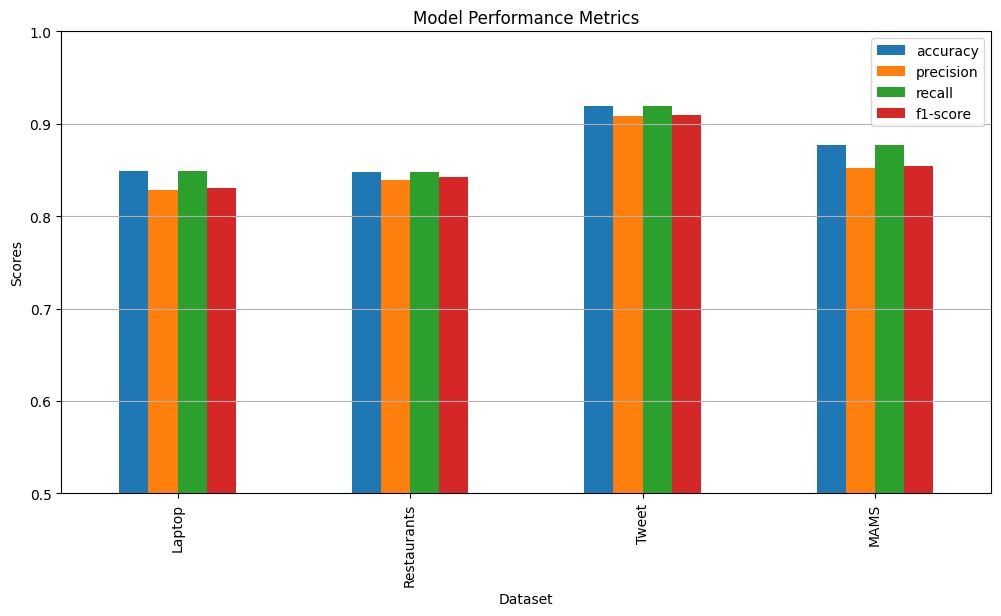

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

# Your existing code to generate predictions and true labels
# ...

# Filter out 'PAD' tag from predictions and true labels
def filter_pad_tags(y_true_flat, y_pred_flat, pad_tag_index):
    non_pad_indices = y_true_flat != pad_tag_index
    y_true_filtered = y_true_flat[non_pad_indices]
    y_pred_filtered = y_pred_flat[non_pad_indices]
    return y_true_filtered, y_pred_filtered

pad_tag_index = tag_to_index['PAD']

# Filter the predictions and true labels
laptop_y_test_labels_filtered, laptop_y_pred_labels_filtered = filter_pad_tags(laptop_y_test_labels_flat, laptop_y_pred_labels_flat, pad_tag_index)
res_y_test_labels_filtered, res_y_pred_labels_filtered = filter_pad_tags(res_y_test_labels_flat, res_y_pred_labels_flat, pad_tag_index)
tweet_y_test_labels_filtered, tweet_y_pred_labels_filtered = filter_pad_tags(tweet_y_test_labels_flat, tweet_y_pred_labels_flat, pad_tag_index)
mams_y_test_labels_filtered, mams_y_pred_labels_filtered = filter_pad_tags(mams_y_test_labels_flat, mams_y_pred_labels_flat, pad_tag_index)

# Generate classification report and extract metrics
def extract_metrics(y_true, y_pred):
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    accuracy = accuracy_score(y_true, y_pred)
    metrics = {
        'accuracy': accuracy,
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1-score': report['weighted avg']['f1-score']
    }
    return metrics

# Extracted metrics
laptop_metrics = extract_metrics(laptop_y_test_labels_filtered, laptop_y_pred_labels_filtered)
res_metrics = extract_metrics(res_y_test_labels_filtered, res_y_pred_labels_filtered)
tweet_metrics = extract_metrics(tweet_y_test_labels_filtered, tweet_y_pred_labels_filtered)
mams_metrics = extract_metrics(mams_y_test_labels_filtered, mams_y_pred_labels_filtered)

# Create a DataFrame
metrics_df = pd.DataFrame([laptop_metrics, res_metrics, tweet_metrics, mams_metrics],
                          index=['Laptop', 'Restaurants', 'Tweet', 'MAMS'])

# Plotting the histograms
metrics_df.plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Metrics')
plt.xlabel('Dataset')
plt.ylabel('Scores')
plt.ylim(0.5, 1)  # Since metrics range from 0 to 1
plt.legend(loc='upper right')
plt.grid(axis='y')

plt.savefig('model_performance_metrics.png', format='png')

# Show the plot
plt.show()


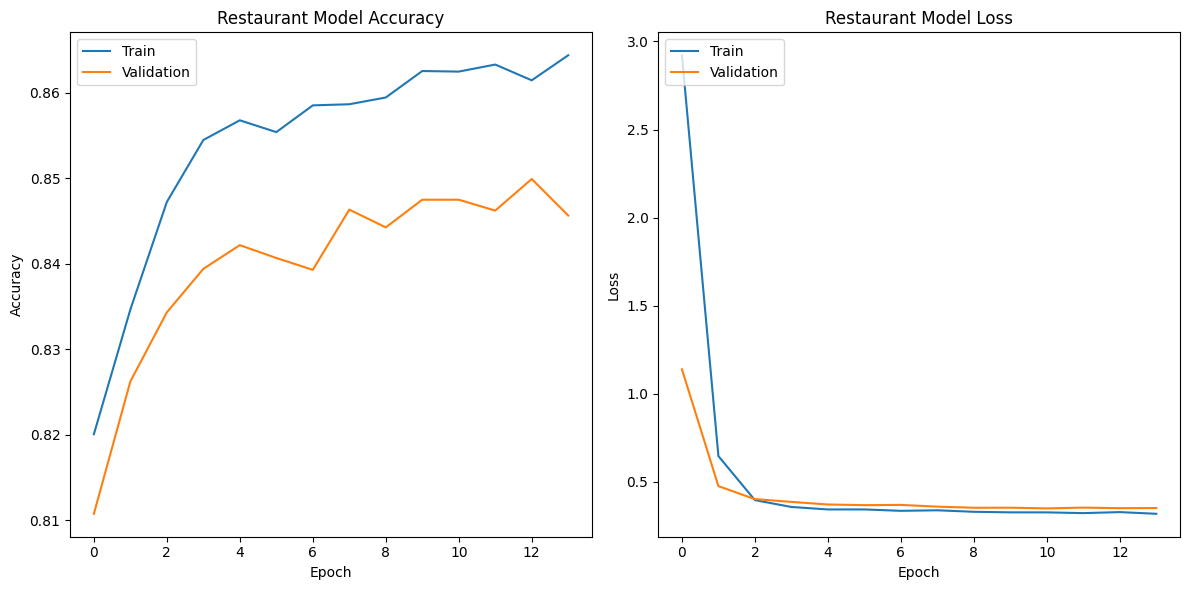

In [ ]:
# Plot Restaurant dataset results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(res_history.history['accuracy'])
plt.plot(res_history.history['val_accuracy'])
plt.title('Restaurant Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(res_history.history['loss'])
plt.plot(res_history.history['val_loss'])
plt.title('Restaurant Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

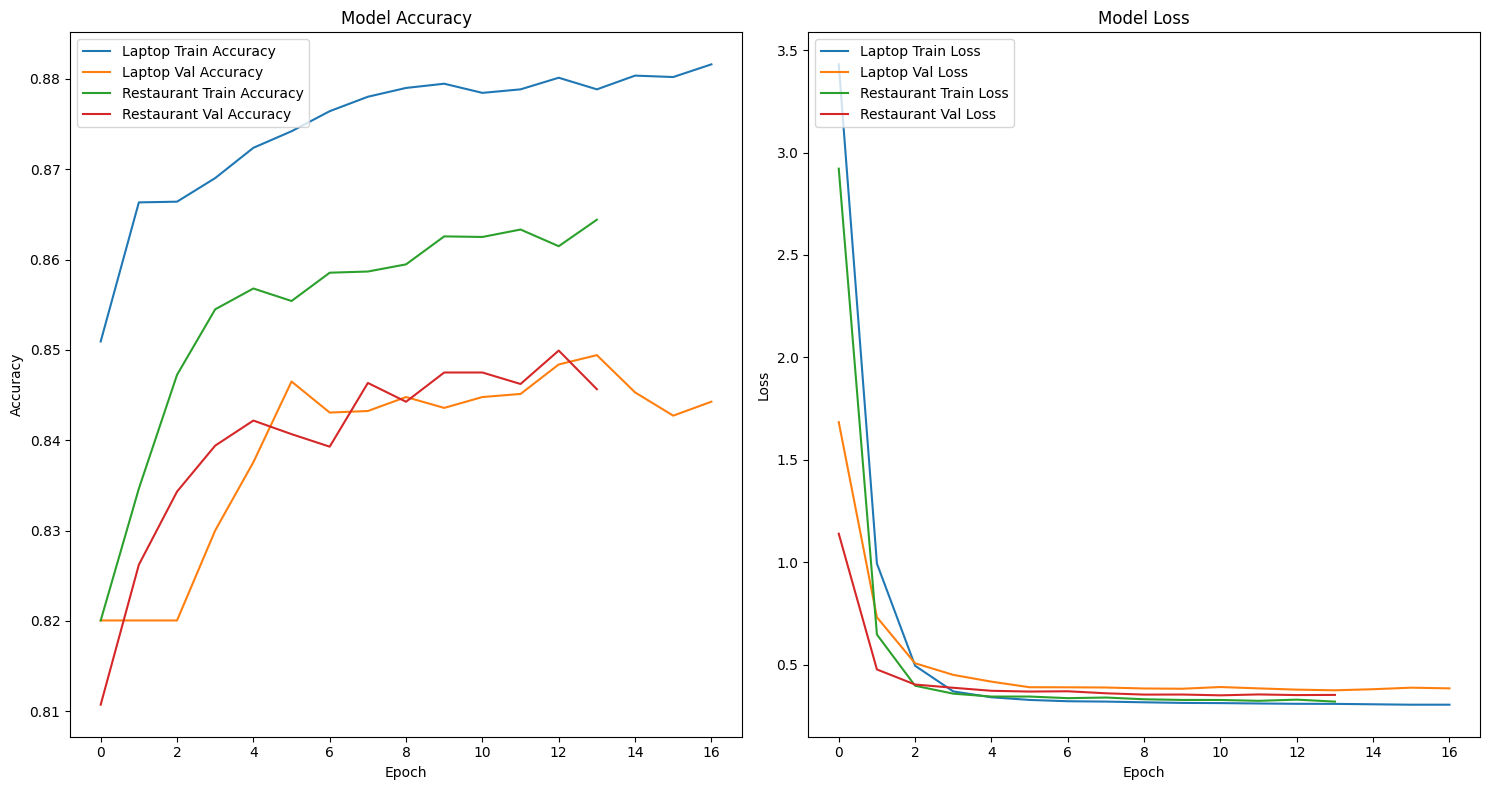

In [ ]:
# Plot accuracy
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(laptop_history.history['accuracy'], label='Laptop Train Accuracy')
plt.plot(laptop_history.history['val_accuracy'], label='Laptop Val Accuracy')
plt.plot(res_history.history['accuracy'], label='Restaurant Train Accuracy')
plt.plot(res_history.history['val_accuracy'], label='Restaurant Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(laptop_history.history['loss'], label='Laptop Train Loss')
plt.plot(laptop_history.history['val_loss'], label='Laptop Val Loss')
plt.plot(res_history.history['loss'], label='Restaurant Train Loss')
plt.plot(res_history.history['val_loss'], label='Restaurant Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.savefig('model_accuracy_loss.png')
plt.show()